In [1]:
from models import UNETModule
import torch
from torch.utils.data import DataLoader


/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Water Bodies Dataset

In [2]:
from datasets import WaterBodiesDataset, SimpleWaterBodiesDataset

root = "../water-segmentation-vtx/dataset/"
train_dataset = SimpleWaterBodiesDataset(root, mode="train")
val_dataset = SimpleWaterBodiesDataset(root, mode="val")

print("Train dataset length:", len(train_dataset))
print("Val dataset length:", len(val_dataset))

Train dataset length: 801
Val dataset length: 90


In [3]:
aosjdas = WaterBodiesDataset(root, mode="val")
aosjdas.__getitem__(0)["mask"].shape

(480, 640)

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

example = val_dataset.__getitem__(0)
image_array = example["image"]
mask_array = example["mask"]
image = Image.fromarray(image_array.transpose(1,2,0), 'RGB')
mask = Image.fromarray((np.squeeze(mask_array, axis=0)*255).astype(np.uint8))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Image")
axes[1].imshow(mask)
axes[1].set_title("Mask")
plt.show()

# print("Image Array:")
# print(image_array)
print("\nMask Array:")
print(mask_array)

print(mask_array.shape)


TypeError: Cannot handle this data type: (1, 1, 640), |u1

#### Dataloader

In [6]:

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

### Training

In [7]:
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

unet_module = UNETModule()

unet_trainer = pl.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-02-26 13:18:42.525300: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 13:18:42.560776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 13:18:43.098222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Wrong input shape height=640, width=3. Expected image height and width divisible by 32. Consider pad your images to shape (640, 32).

In [ ]:
logits  = unet_trainer.predict(unet_module, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]


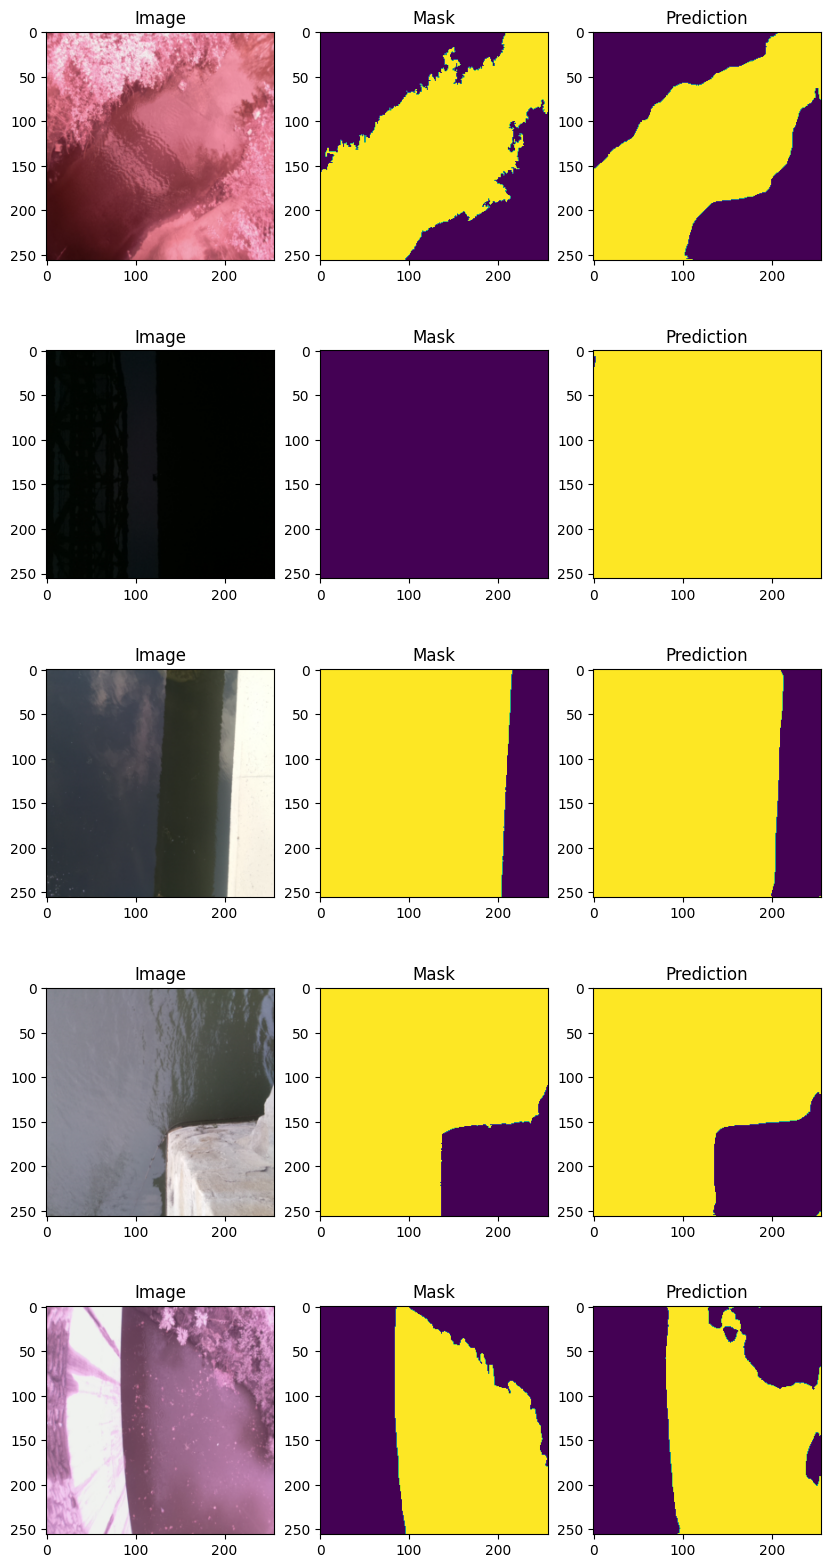

In [ ]:
preds = (torch.sigmoid(logits[0][0]) > 0.5).float()


fig, axes = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    example = val_dataset.__getitem__(i)
    image_array = example["image"]
    mask_array = example["mask"]
    image = Image.fromarray(image_array.transpose(1,2,0), 'RGB')
    mask = Image.fromarray((np.squeeze(mask_array, axis=0)*255).astype(np.uint8))
    prediction = Image.fromarray((np.squeeze(preds[i].cpu().numpy(), axis=0)*255).astype(np.uint8))
    axes[i][0].imshow(image)
    axes[i][0].set_title("Image")
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Mask")
    axes[i][2].imshow(prediction)
    axes[i][2].set_title("Prediction")



In [ ]:
(torch.sigmoid(a[0]) > 0.5).float()

tensor([[[[0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 1., 0., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 0., 0.,  ..., 0., 0., 1.],
          [1., 0., 1.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          ...,
          [0., 0., 0.,  ..., 1.